<a href="https://colab.research.google.com/github/susanta-pal/Deep-Learning/blob/main/shallow_vs_deep_layer_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary libraries

In [ ]:
import torch
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import CIFAR10, FashionMNIST
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
# !pip install torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Setup the Data Class (CIFAR10)
Always create classes for major modules. This will make your project modular, allowing you to switch different, in this case, datasets and test your model.
Out of all the advantages of this coding habit, one advantage of creating multiple objecs of the data class is that it allows you to perform ensemble learning.

In [ ]:
class DataModule():
    def __init__(self, batch_size, num_classes=10):
        super().__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes
        # We define some augmentations that we would like to apply during training
        self.train_transform = transforms.Compose([

            transforms.Resize(256),
            transforms.RandomCrop(224, 4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # During validation we need to only normalize and resize
        self.val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    # This function sets up our datasets
    # which includes downloading and applying the augmentations
    def prepare_data(self):
        self.train_set = CIFAR10(root='./data', train=True, download=True, transform=self.train_transform)
        self.val_set = CIFAR10(root='./data', train=False, download=True, transform=self.val_transform)
        total_indices = list()
        for i in range(self.num_classes):
            indices = np.where(np.asarray(self.train_set.targets)==i)[0]
            indices = np.random.choice(indices, int(0.1*len(indices))).tolist()
            total_indices.extend(indices)
        self.train_set.data = self.train_set.data[total_indices]
        self.train_set.targets = [self.train_set.targets[j] for j in total_indices]


    # This functions sets up the data loaders
    def setup(self):
        self.train_data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.val_data_loader = torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

    # This is simply a getter function for the training data loader
    def train_dataloader(self, prune=True):
        return self.train_data_loader

    # This is simply a getter function for the validation data loader
    def val_dataloader(self):
        return self.val_data_loader

# Setup the Model Class
Here we will define the model, its forward pass and its behaviour during each training/validation iteration

In [ ]:
class DLModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True, fine_tune_shallow=True):
        super().__init__()
        # If you want to use the imagenet pretrained weights
        if pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
            # We freeze the entire model
            self.backbone.requires_grad_ = False
            counter = 0
            # If you want to unfreeze some of the layers, then
            if fine_tune_shallow:
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                if counter <=21:
                    module.requires_grad_ = True
            else:
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                    if counter >= 21:
                        module.requires_grad_ = True
        # Otherwise just initialize the network from scratch
        else:
            self.backbone = resnet18(weights=None)
            self.backbone.requires_grad_ = True
        # The resnet model comes with a 1000 neuron final layer for the imagenet dataset
        self.backbone.fc = torch.nn.Sequential(
            torch.nn.Linear(512, num_classes)
        )
        self.backbone.fc.requires_grad_ = True
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # Define the metrics
        self.train_acc1, self.val_acc1 = Accuracy(task="multiclass", num_classes=num_classes), Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc5, self.val_acc5 = Accuracy(task="multiclass", num_classes=num_classes, top_k=5), Accuracy(task="multiclass", num_classes=num_classes, top_k=5)

    # This function sets up the optimizer and scheduler that we will use
    def configure_optimizers(self, lr, momentum, max_epochs):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs)

    # This defines the behaviour of our model during the forward pass
    # Based on the defined behaviour, PyTorch sets up the backward pass
    def forward(self, x):
        out = self.backbone(x)
        return out

    # This function describes model behaviour per iteration during training
    def training_step(self, x, y):
        self.optimizer.zero_grad()
        preds = self.forward(x)
        self.train_acc1.update(preds, y)
        self.train_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    # Once the epoch is complete, we can call this function for inspecting the model's performance
    def on_training_epoch_end(self, loss, epoch):
        acc1, acc5 = self.train_acc1.compute().item(), self.train_acc5.compute().item()
        print(f"Epoch No: {epoch+1}\nTraining Loss: {loss}\n Training Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function describes model behaviour per iteration during validation
    def validation_step(self, x, y):
        preds = self.forward(x)
        self.val_acc1.update(preds, y)
        self.val_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        return loss.item()

    # Once the validation iterations are complete, we can call this function for inspecting the model's performance
    def on_validation_epoch_end(self, loss, epoch):
        acc1, acc5 = self.val_acc1.compute().item(), self.val_acc5.compute().item()
        print(f"Validation Loss: {loss}\nValidation Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function resets the metrics so that new results can be calculated for the next epoch
    def reset_metrics(self):
        self.train_acc1.reset(), self.train_acc5.reset()
        self.val_acc1.reset(), self.val_acc5.reset()

# Putting it all together
We first define some static and global variables

In [ ]:
# First define some static variables
num_classes = 10
num_epochs = 10
batch_size = 256
# Fine-tuning and training from scratch require different sets of learning rates
lr = 0.01
momentum = 0.9
device = torch.device("cuda")


# Define the data
data_module = DataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

Files already downloaded and verified
Files already downloaded and verified


# Fine-tune shallow layers

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
shallow_val_acc = list()
# This variable will be used to save the per-epoch training loss
shallow_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, fine_tune_shallow=True).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    shallow_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    shallow_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Epoch No: 1
Training Loss: 1.4647930681705474
 Training Accuracy: 0.5016000270843506 (Top-1)	  0.8820000290870667 (Top-5)


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


Validation Loss: 0.8948644280433655
Validation Accuracy: 0.6913999915122986 (Top-1)	  0.9677000045776367 (Top-5)


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Epoch No: 2
Training Loss: 0.5362361878156662
 Training Accuracy: 0.8116000294685364 (Top-1)	  0.9936000108718872 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Validation Loss: 0.6055294036865234
Validation Accuracy: 0.7840999960899353 (Top-1)	  0.9919000267982483 (Top-5)


100%|██████████| 20/20 [00:19<00:00,  1.02it/s]


Epoch No: 3
Training Loss: 0.28849955573678016
 Training Accuracy: 0.9038000106811523 (Top-1)	  0.9980000257492065 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.08it/s]


Validation Loss: 0.3649407044053078
Validation Accuracy: 0.8766000270843506 (Top-1)	  0.9962000250816345 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.03s/it]


Epoch No: 4
Training Loss: 0.17926690429449083
 Training Accuracy: 0.9455999732017517 (Top-1)	  0.9994000196456909 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Validation Loss: 0.34533275552093984
Validation Accuracy: 0.878600001335144 (Top-1)	  0.9972000122070312 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch No: 5
Training Loss: 0.13626587018370628
 Training Accuracy: 0.9588000178337097 (Top-1)	  0.9991999864578247 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


Validation Loss: 0.3117046354338527
Validation Accuracy: 0.8909000158309937 (Top-1)	  0.9972000122070312 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch No: 6
Training Loss: 0.08591618090867996
 Training Accuracy: 0.9797999858856201 (Top-1)	  0.9998000264167786 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Validation Loss: 0.2972279038280249
Validation Accuracy: 0.9035999774932861 (Top-1)	  0.9976000189781189 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch No: 7
Training Loss: 0.06075460407882929
 Training Accuracy: 0.98580002784729 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.84it/s]


Validation Loss: 0.3345754785463214
Validation Accuracy: 0.8916000127792358 (Top-1)	  0.9965999722480774 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch No: 8
Training Loss: 0.04902004785835743
 Training Accuracy: 0.9896000027656555 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.87it/s]


Validation Loss: 0.28853566013276577
Validation Accuracy: 0.9049000144004822 (Top-1)	  0.9979000091552734 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch No: 9
Training Loss: 0.03649479793384671
 Training Accuracy: 0.9927999973297119 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


Validation Loss: 0.28973713554441927
Validation Accuracy: 0.9063000082969666 (Top-1)	  0.9976999759674072 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch No: 10
Training Loss: 0.027827535942196845
 Training Accuracy: 0.9958000183105469 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.93it/s]

Validation Loss: 0.2912087207660079
Validation Accuracy: 0.9050999879837036 (Top-1)	  0.9977999925613403 (Top-5)


# Fine-tune Deep

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
deep_val_acc = list()
# This variable will be used to save the per-epoch training loss
deep_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, fine_tune_shallow=False).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    deep_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    deep_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch No: 1
Training Loss: 1.5075565040111543
 Training Accuracy: 0.48660001158714294 (Top-1)	  0.8468000292778015 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.94it/s]


Validation Loss: 0.9728006765246391
Validation Accuracy: 0.6650000214576721 (Top-1)	  0.9617000222206116 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch No: 2
Training Loss: 0.5163685351610183
 Training Accuracy: 0.8144000172615051 (Top-1)	  0.993399977684021 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.95it/s]


Validation Loss: 0.4800040774047375
Validation Accuracy: 0.8389000296592712 (Top-1)	  0.9944000244140625 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch No: 3
Training Loss: 0.30838340520858765
 Training Accuracy: 0.8989999890327454 (Top-1)	  0.9986000061035156 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.98it/s]


Validation Loss: 0.37700149416923523
Validation Accuracy: 0.8694000244140625 (Top-1)	  0.9957000017166138 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch No: 4
Training Loss: 0.1943768098950386
 Training Accuracy: 0.9399999976158142 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Validation Loss: 0.3284688353538513
Validation Accuracy: 0.8878999948501587 (Top-1)	  0.9972000122070312 (Top-5)


100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


Epoch No: 5
Training Loss: 0.12547749988734722
 Training Accuracy: 0.9660000205039978 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.05it/s]


Validation Loss: 0.3503215195611119
Validation Accuracy: 0.8795999884605408 (Top-1)	  0.9959999918937683 (Top-5)


100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


Epoch No: 6
Training Loss: 0.09672139286994934
 Training Accuracy: 0.972000002861023 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.02it/s]


Validation Loss: 0.3014507764950395
Validation Accuracy: 0.9002000093460083 (Top-1)	  0.9980000257492065 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch No: 7
Training Loss: 0.06410870291292667
 Training Accuracy: 0.9861999750137329 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.01it/s]


Validation Loss: 0.2960917163640261
Validation Accuracy: 0.9024999737739563 (Top-1)	  0.9979000091552734 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch No: 8
Training Loss: 0.04617990357801318
 Training Accuracy: 0.9911999702453613 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Validation Loss: 0.3288421411067247
Validation Accuracy: 0.8913000226020813 (Top-1)	  0.9965000152587891 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch No: 9
Training Loss: 0.0366427518427372
 Training Accuracy: 0.9947999715805054 (Top-1)	  0.9998000264167786 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.99it/s]


Validation Loss: 0.30844201166182755
Validation Accuracy: 0.8973000049591064 (Top-1)	  0.9975000023841858 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Epoch No: 10
Training Loss: 0.03132599433884024
 Training Accuracy: 0.9936000108718872 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  2.00it/s]

Validation Loss: 0.2902513526380062
Validation Accuracy: 0.9038000106811523 (Top-1)	  0.9977999925613403 (Top-5)


# Comparisons
Now that we have evaluated the models for two different datasets, let us compare them
We expect that the performance of ResNet18 on MNIST should be considerably worse than CIFAR10 due to reduced domain adaptability

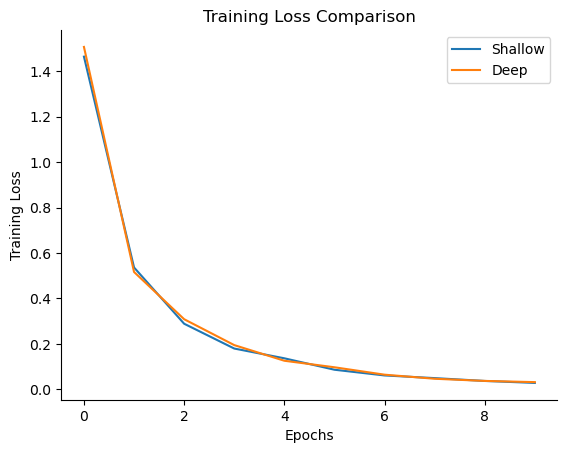

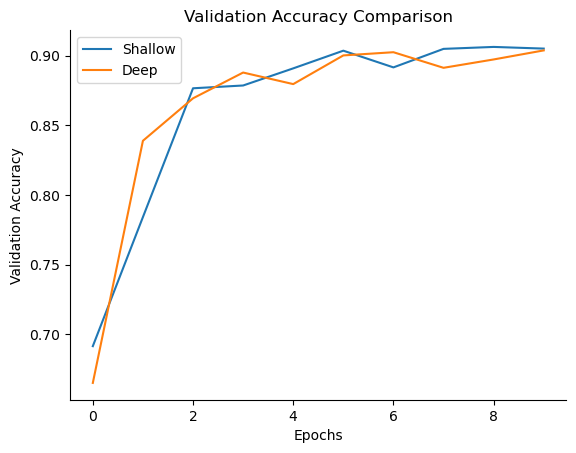

In [ ]:
# Comparing the Training loss per epoch
sns.lineplot(x=np.arange(len(shallow_train_loss)), y=shallow_train_loss, label="Shallow")
sns.lineplot(x=np.arange(len(deep_train_loss)), y=deep_train_loss, label="Deep")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
sns.despine()
plt.title("Training Loss Comparison")
plt.show()
plt.close()

# Comparing the validation Accuracies per epoch
sns.lineplot(x=np.arange(len(shallow_val_acc)), y=shallow_val_acc, label="Shallow")
sns.lineplot(x=np.arange(len(deep_val_acc)), y=deep_val_acc, label="Deep")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.title("Validation Accuracy Comparison")
plt.show()